In [1]:
from pandas import read_csv
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from keras.optimizers import Adam
from keras.layers import Dropout

data = pd.read_csv("clean_indonesia_data.csv")

data.head()

,date,cases,vaccin,fully_vaccin
0,2020-03-02,2.0,0.0,0.0
1,2020-03-03,0.0,0.0,0.0
2,2020-03-04,0.0,0.0,0.0
3,2020-03-05,0.0,0.0,0.0
4,2020-03-06,2.0,0.0,0.0


In [2]:
del data['date']
del data['vaccin']
del data['fully_vaccin']


data.head()

,cases
0,2.0
1,0.0
2,0.0
3,0.0
4,2.0


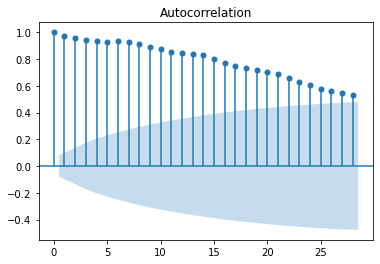

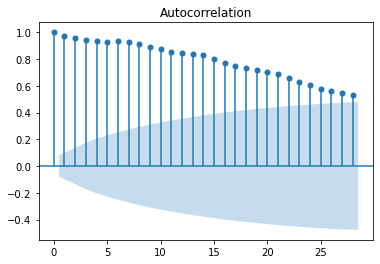

In [3]:
#Autocorellation Test
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
target=data["cases"]
plot_acf(target)

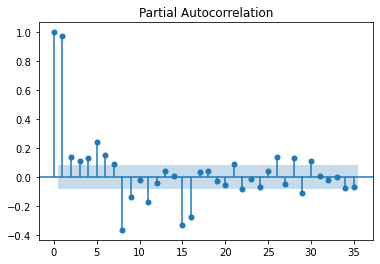

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(target, lags=35)
pyplot.show()

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
values = data.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
reframed = series_to_supervised(scaled, 7, 1)

In [8]:
reframed

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.000035,0.000000,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229
8,0.000000,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141
9,0.000000,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123
10,0.000000,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000
11,0.000035,0.000000,0.000035,0.000229,0.000141,0.000123,0.000000,0.000617
...,...,...,...,...,...,...,...,...
598,0.018553,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153
599,0.016121,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390
600,0.017566,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390,0.014130
601,0.013161,0.011029,0.015910,0.016104,0.011153,0.013390,0.014130,0.010977


In [9]:
values = reframed.values

train = values[:-97, :]
test = values[-97:-7, :]
predict = values[-7:, :]

train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
predict_X, predict_y = predict[0, :-1], predict[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((1, 1, 7))

In [10]:
train_X.shape

(499, 1, 7)

In [11]:
model = Sequential()
model.add(LSTM(11, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.01))
model.add(Dense(1))

sgd = Adam(lr=0.001,decay=0.01)

model.compile(loss='mae', optimizer='sgd')

history = model.fit(train_X, train_y, epochs=500, batch_size = 30, validation_data = (test_X, test_y), verbose=0, shuffle=False)

C:\Users\AchmadFai\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


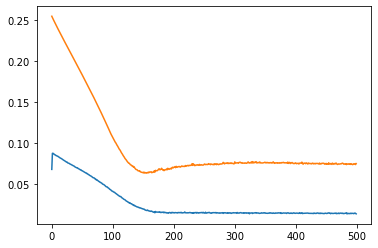

In [12]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend
plt.show()

In [13]:
yhat = model.predict(test_X)

#invert scaling for forecast
yhat = yhat.reshape((90, 1))
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
test_y = test_y.reshape((90, 1))
inv_y = scaler.inverse_transform(test_y)


# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6500.510


In [14]:
np.std(inv_y)

14768.888

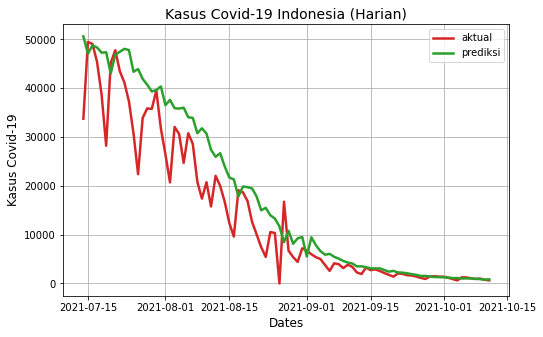

In [15]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2021-7-14", periods=90)

# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x, inv_y, color="tab:red", label="aktual", linewidth=2.5)
ax.plot(x, inv_yhat, color="tab:green", label="prediksi", linewidth=2.5)


# membuat label-label
ax.set_title("Kasus Covid-19 Indonesia (Harian)", fontsize=14)
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel("Kasus Covid-19", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [16]:
evaluasi = model.predict(train_X)

#invert scaling for forecast
evaluasi = evaluasi.reshape((499, 1))
inv_evaluasi = scaler.inverse_transform(evaluasi)

# invert scaling for actual
train_y = train_y.reshape((499, 1))
inv_ytrain = scaler.inverse_transform(train_y)

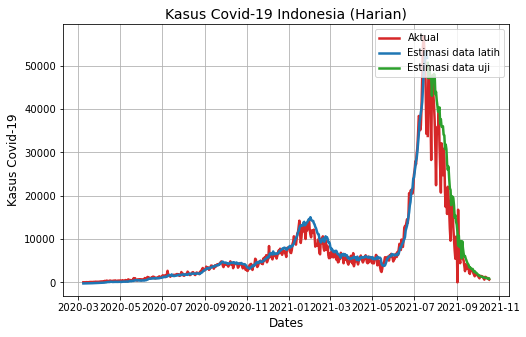

In [17]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x1 = pd.date_range(start="2020-3-9", periods=499)
x2 = pd.date_range(start="2021-7-21", periods=90)


# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x1, inv_ytrain, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x1, inv_evaluasi, color="tab:blue", label="Estimasi data latih", linewidth=2.5)
ax.plot(x2, inv_y, color="tab:red", linewidth=2.5)
ax.plot(x2, inv_yhat, color="tab:green", label="Estimasi data uji", linewidth=2.5)

# membuat label-label
ax.set_title("Kasus Covid-19 Indonesia (Harian)", fontsize=14)
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel("Kasus Covid-19", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [18]:
yhat = model.predict(predict_X)
prediksi = [yhat[0]]

for i in range (6):
    predict_X = np.delete(predict_X[0][0], 0)
    predict_X = np.append(predict_X, yhat)
    predict_X = predict_X.reshape((1, 1, 7))
    yhat = model.predict(predict_X)
    prediksi.append(yhat[0])
        
inv_prediksi = scaler.inverse_transform(prediksi)

predict_y = predict_y.reshape((7, 1))
inv_ypredict = scaler.inverse_transform(predict_y)

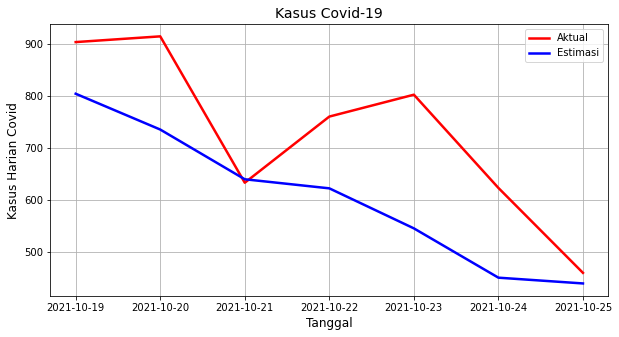

In [26]:
x = pd.date_range(start="2021-10-19", periods=7)

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(x, inv_ypredict, color="red", label="Aktual", linewidth=2.5)
ax.plot(x, inv_prediksi, color="blue", label="Estimasi", linewidth=2.5)


# membuat label-label
ax.set_title("Kasus Covid-19", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Kasus Harian Covid", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [20]:
np.std(inv_ypredict)

152.87477

In [21]:
rmse = sqrt(mean_squared_error(inv_ypredict, inv_prediksi))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 149.663


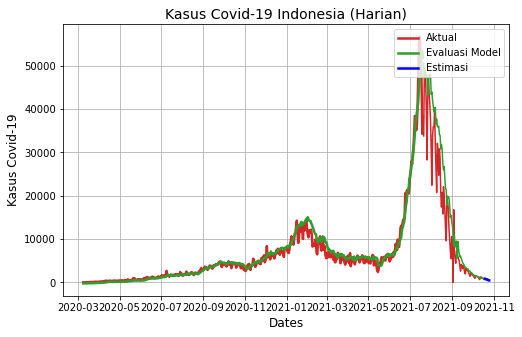

In [24]:
import pandas as pd
# generate urutan data sesuai panjang datanya
x1 = pd.date_range(start="2020-3-9", periods=499)
x2 = pd.date_range(start="2021-7-21", periods=90)
x3 = pd.date_range(start="2021-10-19", periods=7)

# membuat frame
fig, ax = plt.subplots(figsize = (8,5))

# membuat time series plot
ax.plot(x1, inv_ytrain, color="tab:red", label="Aktual", linewidth=2.5)
ax.plot(x1, inv_evaluasi, color="tab:green", label="Evaluasi Model", linewidth=2.5)
ax.plot(x2, inv_y, color="tab:red")
ax.plot(x2, inv_yhat, color="tab:green")
ax.plot(x3, inv_ypredict, color="tab:red")
ax.plot(x3, inv_prediksi, color="blue", label="Estimasi", linewidth=2.5)

# membuat label-label
ax.set_title("Kasus Covid-19 Indonesia (Harian)", fontsize=14)
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel("Kasus Covid-19", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()